 # Math Topic Classification - Embedding Analysis and Model Training



 This notebook analyzes the embeddings generated from math questions and trains models using:

 1. Embedding visualization with t-SNE

 2. H2O AutoML

 3. PyCaret AutoML

 ## Setup and Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import h2o
from h2o.automl import H2OAutoML
from pycaret.classification import *
from config import DATA_CONFIG, TOPICS

# Set random seed for reproducibility
np.random.seed(42)


 ## Load Data and Embeddings

In [2]:
# Load the original data
train_df = pd.read_csv(DATA_CONFIG['train_path'])
print("Training data shape:", train_df.shape)

# Load embeddings
train_embeddings = np.load('embeddings/train_embeddings.npy')
print("Training embeddings shape:", train_embeddings.shape)

# Create feature names for embeddings
embedding_features = [f'emb_{i}' for i in range(train_embeddings.shape[1])]

# Combine data
X_train = pd.DataFrame(train_embeddings, columns=embedding_features)
y_train = train_df['label']


Training data shape: (10189, 2)
Training embeddings shape: (10189, 1024)


 ## Embedding Visualization with t-SNE

Performing t-SNE dimensionality reduction...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

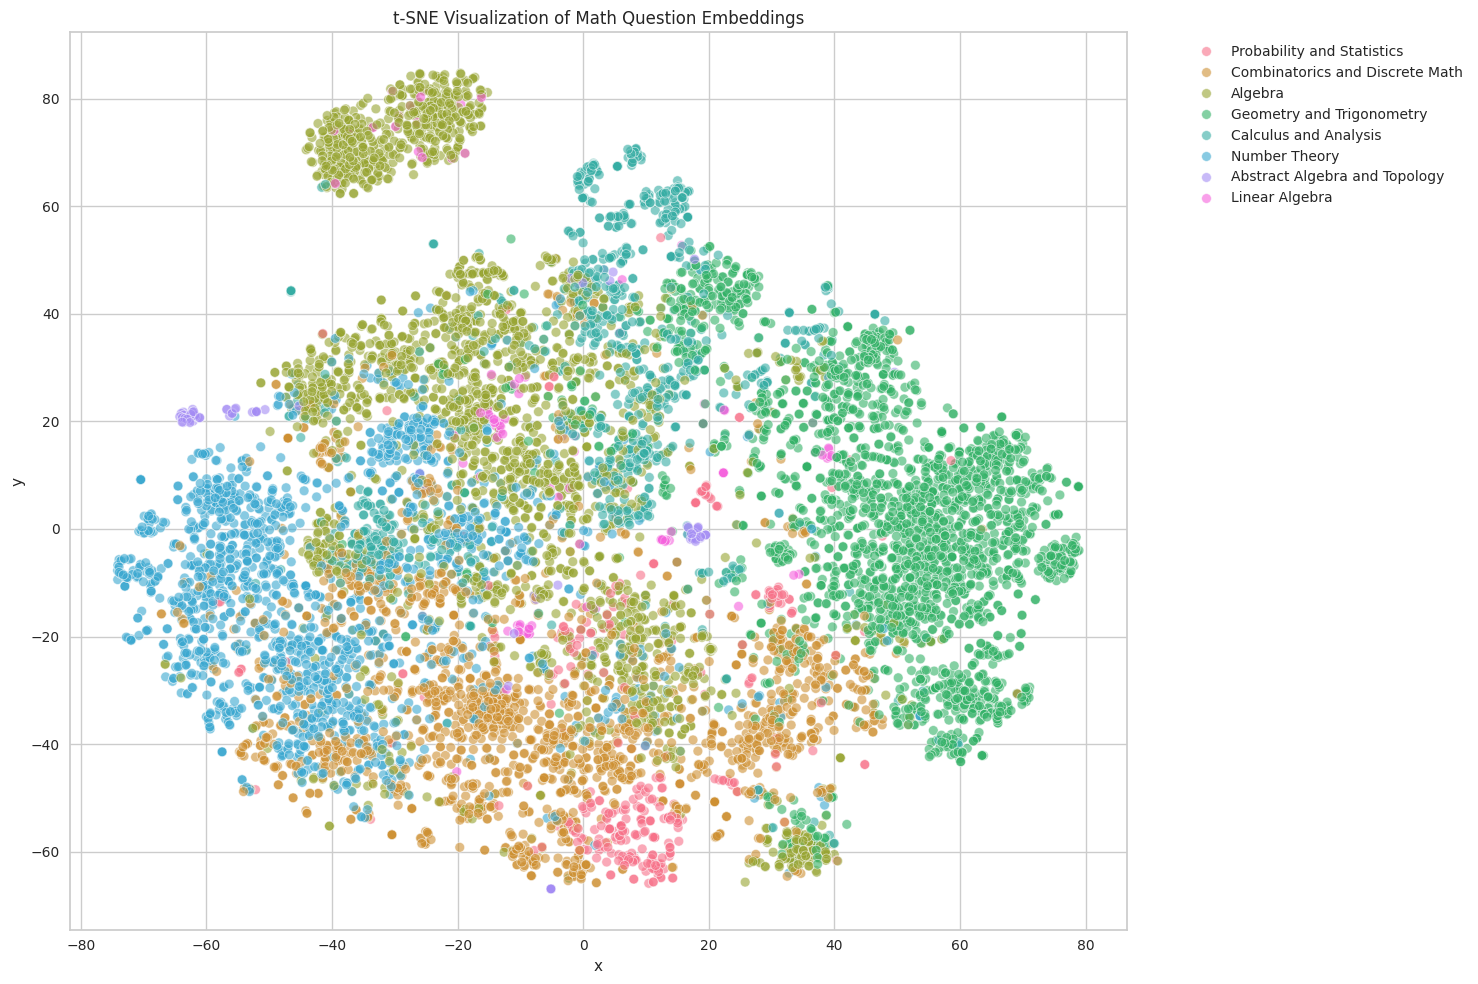

In [3]:
# Perform t-SNE dimensionality reduction
print("Performing t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(train_embeddings)

# Create visualization DataFrame
viz_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'topic': [TOPICS[label] for label in y_train]
})

# Plot
plt.figure(figsize=(15, 10))
sns.scatterplot(data=viz_df, x='x', y='y', hue='topic', alpha=0.6)
plt.title('t-SNE Visualization of Math Question Embeddings')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


 ## H2O AutoML Training

In [6]:
# Initialize H2O
h2o.init()

# Convert data to H2O frames
train_h2o = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))

# Set the role of the response column
train_h2o['label'] = train_h2o['label'].asfactor()

# Initialize and train H2O AutoML
aml = H2OAutoML(
    max_runtime_secs=600,  # 10 minutes
    seed=42,
    sort_metric='mean_per_class_error'
)

print("Training H2O AutoML models...")
aml.train(y='label', training_frame=train_h2o)

# Print leaderboard
print("\nH2O AutoML Leaderboard:")
print(aml.leaderboard)

# Get model performance
print("\nBest Model Performance:")
print(aml.leader.model_performance(train_h2o))


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /root/miniconda3/envs/myenv/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpphhjw4ah
  JVM stdout: /tmp/tmpphhjw4ah/h2o_root_started_from_python.out
  JVM stderr: /tmp/tmpphhjw4ah/h2o_root_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_root_drgdfy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.97 Gb
H2O_cluster_total_cores:,62
H2O_cluster_allowed_cores:,62
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training H2O AutoML models...
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%

H2O AutoML Leaderboard:
model_id                                                   mean_per_class_error    logloss      rmse       mse
StackedEnsemble_BestOfFamily_1_AutoML_1_20250430_170039                0.210055   0.371754  0.33877   0.114765
StackedEnsemble_BestOfFamily_2_AutoML_1_20250430_170039                0.210967   0.373063  0.339085  0.114979
StackedEnsemble_AllModels_1_AutoML_1_20250430_170039                   0.213789   0.373472  0.339363  0.115167
GLM_1_AutoML_1_20250430_170039                                         0.215623   0.376077  0.339898  0.11553
XGBoost_1_AutoML_1_20250430_170039                                     0.237548   0.430466  0.352269  0.124093
GBM_1_AutoML_1_20250430_170039                                         0.260017   0.422524

In [9]:
aml.leader

key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/3
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


In [25]:
# predict on test set
test_embeddings = np.load('embeddings/test_embeddings.npy')

# Create feature names for embeddings
embedding_features = [f'emb_{i}' for i in range(test_embeddings.shape[1])]

# Combine data
X_test = pd.DataFrame(test_embeddings, columns=embedding_features)
test_h2o = h2o.H2OFrame(X_test)

# predict on test set
predictions = aml.leader.predict(test_h2o)

# get class predictions
pred_df = predictions.as_data_frame()

predicted_labels = pd.DataFrame(pred_df['predict'].values, columns=['label'])  # string/int class labels

predicted_labels.to_csv('test_predictions.csv', index=True, index_label='id')
print("✅ Predictions saved to predictions/test_predictions.csv")



Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
✅ Predictions saved to predictions/test_predictions.csv


 ## PyCaret AutoML Training

In [8]:
# Initialize PyCaret setup
print("Initializing PyCaret...")
clf = setup(
    data=pd.concat([X_train, y_train], axis=1),
    target='label',
    verbose=False
)

# Train models using PyCaret
print("Training models with PyCaret...")
best_model = compare_models(
    n_select=3,
    sort='f1',
    verbose=True
)

# Plot model performance
plot_model(best_model, plot='confusion_matrix')
plot_model(best_model, plot='class_report')


Initializing PyCaret...


Training models with PyCaret...


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:37:53
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8441,0.0000,0.8441,0.8462,0.8421,0.8052,0.8056,0.2570
lr,Logistic Regression,0.8348,0.0000,0.8348,0.8361,0.8346,0.7945,0.7947,1.3250
svm,SVM - Linear Kernel,0.8302,0.0000,0.8302,0.8372,0.8301,0.7887,0.7900,0.3620
knn,K Neighbors Classifier,0.8103,0.9509,0.8103,0.8150,0.8078,0.7627,0.7639,0.3120
rf,Random Forest Classifier,0.8092,0.9700,0.8092,0.8066,0.7979,0.7591,0.7611,0.6550
nb,Naive Bayes,0.7514,0.9561,0.7514,0.7857,0.7559,0.6968,0.7022,0.2610
dt,Decision Tree Classifier,0.5928,0.7508,0.5928,0.5965,0.5936,0.4948,0.4951,1.4480
qda,Quadratic Discriminant Analysis,0.5421,0.0000,0.5421,0.5766,0.4413,0.3942,0.4516,0.4030
ada,Ada Boost Classifier,0.4544,0.0000,0.4544,0.4596,0.4201,0.2998,0.3173,4.9850


KeyboardInterrupt: 

 ## Cleanup

In [ ]:
# Shutdown H2O cluster
h2o.cluster().shutdown() 